In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import requests
import zipfile
import os
from scipy.io import loadmat
import seaborn as sns

import jaxley as jx
import pickle

from scipy.ndimage import zoom
mpl.rc_file('../../.matplotlibrc')

In [3]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

response = requests.get(url)
with open('mnist.npz', 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile('mnist.npz', 'r') as zip_ref:
    zip_ref.extractall()

os.remove('mnist.npz')
os.remove('x_test.npy')
os.remove('y_test.npy')

x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

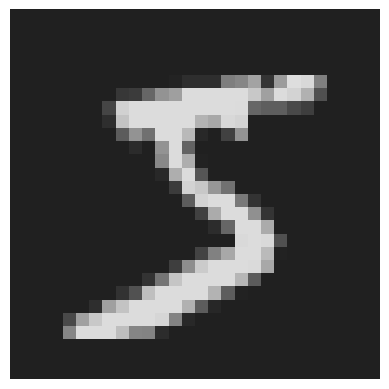

In [4]:
# add luminance and contrast variation
def adjust_luminance_contrast(image, luminance=0, contrast=1.0):
    img_float = image.astype(np.float32)
    luminance = luminance.reshape(-1, 1, 1)
    contrast = contrast.reshape(-1, 1, 1)
    img_float += luminance
    img_float = 127.5 + contrast * (img_float - 127.5)
    img_adjusted = np.clip(img_float, 0, 255)
    return img_adjusted.astype(np.uint8)

np.random.seed(42)
x_train = adjust_luminance_contrast(x_train, *np.random.rand(2, x_train.shape[0]))

plt.imshow(x_train[0], cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()


Original shape: (60000, 28, 28)
Downsampled shape: (10, 17, 17)


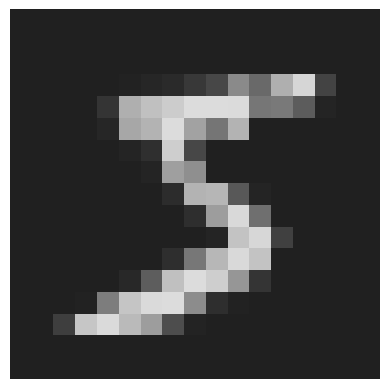

In [5]:
downsample_factor = 0.6

x_train_downsampled = np.array([zoom(img, downsample_factor, order=1) for img in x_train[:10]])

print(f"Original shape: {x_train.shape}")
print(f"Downsampled shape: {x_train_downsampled.shape}")

plt.imshow(x_train_downsampled[0], cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

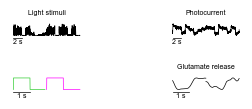

In [8]:
def load_cascade_data(data_path: str):
    "Load stimuli and data."
    data = loadmat(data_path)
    responses = np.vstack([data['ConeResponses'][0][i][0][0][0][0] for i in range(6)])
    stimuli = np.vstack([data['ConeResponses'][0][i][0][0][1][0] for i in range(6)])
    return responses, stimuli


def load_ribbon_data(data_path: str):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data

def norm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data_dir = "../../data/sbi_pr"
dt_cascade_data = 0.1 # ms
ts_cascade_data = np.arange(0, 160_000)*dt_cascade_data
i_photo_data, cascade_stim_data = load_cascade_data("../../../data/RiekeMouseConeResponses.mat")

glutamate_data = load_ribbon_data("../../../data/120_center_responses.pkl")
dt_ribbon_data = (1 / 500)  # sampling rate, 500Hz
ts_ribbon_data = np.arange(0, glutamate_data.shape[1])*dt_ribbon_data * 1000 # ms

phi_max = 20_000
tsteps = 2000
ribbon_stim = np.zeros((2, tsteps))
ribbon_stim[0, 1:500] = phi_max # green center flash
ribbon_stim[1, 1001:1500] = phi_max # uv center flash

fig, axes = plt.subplots(3, 3, figsize=(3.0, 0.9), width_ratios=[1, 0.8, 1], height_ratios=[1, 2.0, 1])
axes[0, 0].plot(ts_cascade_data, norm(cascade_stim_data[0]), color="k", linewidth=0.5)
axes[0, 2].plot(ts_cascade_data, norm(i_photo_data[2].T), color="k", linewidth=0.5)

axes[0, 0].plot([0, 2000], [-0.2, -0.2], color="k", linewidth=0.5)
axes[0, 0].text(1050, -0.3, "2 s", fontsize=5, ha="center", va="top")
axes[0, 2].plot([0, 2000], [-0.2, -0.2], color="k", linewidth=0.5)
axes[0, 2].text(1050, -0.3, "2 s", fontsize=5, ha="center", va="top")

axes[2, 0].plot(ts_ribbon_data[:950], norm(ribbon_stim[0][:950]), color="limegreen", linewidth=0.5)
axes[2, 0].plot(ts_ribbon_data[1000:], norm(ribbon_stim[1][1000:]), color="magenta", linewidth=0.5)
axes[2, 0].set_axis_off()


axes[2, 0].plot([0, 1000], [-0.2, -0.2], color="k", linewidth=0.5)
axes[2, 0].text(500, -0.3, "1 s", fontsize=5, ha="center", va="top")

axes[2, 2].plot(ts_ribbon_data[:1000], norm(glutamate_data[2][:1000]), color="k", linewidth=0.5)
axes[2, 2].plot(ts_ribbon_data[1001:], norm(glutamate_data[2][1001:]), color="k", linewidth=0.5)


axes[2, 2].set_axis_off()
axes[2, 2].plot([0, 1000], [-0.2, -0.2], color="k", linewidth=0.5)
axes[2, 2].text(500, -0.3, "1 s", fontsize=5, ha="center", va="top")

axes[0,0].set_title("Light stimuli", fontsize=5)
axes[0,2].set_title("Photocurrent", fontsize=5)
axes[2,2].set_title("Glutamate release", fontsize=5)

for ax in axes.flatten():
    ax.set_axis_off()

plt.savefig('../svgs/photoreceptor_opt.svg', transparent=True)
plt.show()

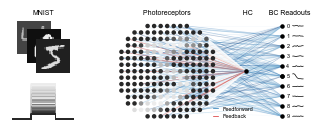

In [ ]:
xs_photo = np.linspace(-1, 1, x_train_downsampled.shape[1])
ys_photo = np.linspace(1, -1, x_train_downsampled.shape[2])
xs_photo, ys_photo = np.meshgrid(xs_photo, ys_photo)
xs_photo = xs_photo.flatten()
ys_photo = ys_photo.flatten()

circle = np.sqrt(xs_photo**2 + ys_photo**2) < 1.0
xs_photo = xs_photo[circle]
ys_photo = ys_photo[circle]

mnist_cmap = plt.cm.Greys_r
mnist_sample = x_train_downsampled[0]

pointsize = 5
line_width = 0.5


x_hc = 1.5
y_hc = 0
num_readouts = 10
xs_readout = 2.2*np.ones(num_readouts)
ys_readout = np.linspace(np.max(ys_photo), np.min(ys_photo), num_readouts)

fig, axes = plt.subplots(2,3, figsize=(3.9, 1.3), width_ratios=[0.4, 0.001, 1.2], height_ratios=[1.0, 0.75])
gs = axes[0, 1].get_gridspec()
# remove the underlying Axes
axes[0, 2].remove()
axes[1, 2].remove()
right_ax = fig.add_subplot(gs[:, 2])

# plot a white rectangle on the right ax
right_ax.add_patch(plt.Polygon([[0.8, 0.6], [1.5, 0.0], [0.8, -0.6]], fill=True, color="w", alpha=0.8, zorder=5))

# color by actual gS?
hc_pr_colors = plt.cm.Reds(np.random.rand(len(xs_photo)))
pr_hc_colors = plt.cm.Blues(np.random.rand(len(xs_photo)))
p_connect = 0.1 # only for visualization
for x, y, c_fw, c_bw in zip(xs_photo, ys_photo, hc_pr_colors, pr_hc_colors):
    # readouts - prs
    pr_readout_colors = plt.cm.Blues(np.random.rand(len(xs_readout)))
    for xr, yr, c in zip(xs_readout, ys_readout, pr_readout_colors):
        if p_connect > np.random.rand():
            right_ax.plot([x, xr], [y, yr], color=c, alpha=0.3, linewidth=line_width, zorder=1)

    # hc-pr connections
    if p_connect > np.random.rand():
        right_ax.plot([x, x_hc], [y, y_hc], color=c_bw, alpha=0.4, linewidth=line_width, zorder=7)
    if p_connect > np.random.rand():
        right_ax.plot([x_hc, x], [y_hc, y], color=c_fw, alpha=0.4, linewidth=line_width, zorder=7)


# photo-receptors
right_ax.scatter(xs_photo, ys_photo, color=mnist_cmap(mnist_sample.flatten()[circle]), marker="o", zorder=10, s=pointsize)

# hc
right_ax.scatter(x_hc, y_hc, color="k", zorder=10, s=pointsize)

# readout layer
right_ax.scatter(xs_readout, ys_readout, color="k", zorder=10, s=pointsize)
right_ax.scatter(xs_readout[5], ys_readout[5], color="k", zorder=11, s=pointsize) # 5th readout


# readout voltages
x_offset = 0.2
x_readout_voltages = np.linspace(xs_readout[0]+x_offset, xs_readout[0]+0.4, 10)
np.random.seed(0)
# Add text labels next to readout points
label_x_offset = 0.08 # Offset for the text label
label_y_offset = 0.00 # Vertical offset for the text label (adjust if needed)
for i, (x, y) in enumerate(zip(xs_readout, ys_readout)):
    noise_floor = 0.005*np.random.randn(10)
    if i == 5:
        right_ax.plot(x_readout_voltages, noise_floor+0.1/(1 + np.exp(np.linspace(-5, 10.0, 10))) + y - 0.05, color="k", linewidth=line_width)
        right_ax.text(x + label_x_offset, y + label_y_offset, str(i),
            verticalalignment='center', horizontalalignment='left',
            color="k", fontsize=4)
    else:
        right_ax.plot(x_readout_voltages, noise_floor+y, color="k", linewidth=line_width)
        right_ax.text(x + label_x_offset, y + label_y_offset, str(i),
                verticalalignment='center', horizontalalignment='left',
                color="k", fontsize=4)

# MNIST Samples
# TODO: add luminance / contrast variation?
# Create a single figure and axes
n_images = 3
offset = 8 # Pixels to offset each image
width, height = x_train[0].shape # Get image dimensions (assuming square)

for i in range(n_images):
    # Calculate extent: [left, right, bottom, top]
    x_start = i * offset
    y_start = i * offset
    img_extent = [x_start, x_start + width, y_start + height, y_start]

    # Plotting in reverse order (2, 1, 0) ensures image 0 is on top
    idx = n_images - 1 - i
    axes[0,0].imshow(x_train[idx], cmap='gray', extent=img_extent, vmin=0, vmax=255)

# Set axis limits to encompass all images
total_width = width + (n_images - 1) * offset
total_height = height + (n_images - 1) * offset
axes[0,0].set_xlim(0, total_width)
axes[0,0].set_ylim(total_height, 0)

# Remove ticks and frame
axes[0,0].set_frame_on(False)
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

# light stimulus
light_stim = mnist_sample.reshape(-1, 1).repeat(1000, axis=1).T
light_stim[-300:] = 0
light_stim[:300] = 0

# color by the greyscale value of the
for line in light_stim.T:
    axes[1,0].plot(line, color=mnist_cmap(np.max(line)), linewidth=line_width)

# Add titles and labels
axes[0,0].set_title("MNIST", fontsize=5, ha="center", va="center")
# add 3 text labels for photo receptors, hc, and readout to the top of the right ax
pr_pad, hc_pad, bc_pad = 14, 26, 8
right_ax.set_title(" "*pr_pad + "Photoreceptors" + " "*hc_pad + "HC" + " "*bc_pad + "BC Readouts", fontsize=5, ha="center", va="center", loc="center")

# legend for feedforward and feedback connections
right_ax.plot([0,0.1], [0,0], color="tab:blue", label="Feedforward", linewidth=line_width, markersize=2)
right_ax.plot([0,0.1], [0,0], color="tab:red", label="Feedback", linewidth=line_width, markersize=2)
right_ax.legend(loc=(0.49, 0.0), fontsize=4, frameon=False, handlelength=1)

# turn off all axes
right_ax.axis('off')
for ax in axes.flatten():
    ax.axis('off')

plt.savefig('../svgs/photoreceptor_mnist.svg', transparent=True)